# TinyGPT Tutorial: Building and Training a Minimal Transformer

This notebook walks through a complete implementation of a tiny GPT model using PyTorch. We'll:

1. **Define** the TinyGPT architecture
2. **Prepare** simple training data  
3. **Train** the model on next-token prediction
4. **Generate** text samples

The model uses:
- Token embeddings + positional embeddings
- Transformer encoder layers with causal masking
- A language modeling head for predictions


In [51]:
# Essential imports for our transformer implementation
import torch                    # Core PyTorch library
import torch.nn as nn          # Neural network modules (layers, loss functions)
import torch.optim as optim    # Optimizers (Adam, SGD, etc.)
import numpy as np             # For numerical operations
import matplotlib.pyplot as plt # For plotting training loss

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())


PyTorch version: 2.10.0.dev20250918
CUDA available: False
MPS available: True


## TinyGPT Architecture

Our model is a **decoder-only transformer** with these components:

- **Token Embedding**: Maps token IDs to dense vectors
- **Position Embedding**: Adds positional information to tokens
- **Transformer Layers**: Self-attention + feedforward networks
- **Causal Mask**: Ensures autoregressive generation (can only see previous tokens)
- **Language Head**: Projects hidden states to vocabulary logits


In [ ]:
class TinyGPT(nn.Module):
    """
    Minimal decoder-only Transformer:
    - token embedding + learned positional embedding
    - TransformerEncoder with a *causal* mask (autoregressive)
    - linear head to vocabulary logits
    """
    def __init__(self, vocab_size: int, d_model=192, nhead=6, nlayers=3, dropout=0.1, block_size=64):
        # d_model = size of emberddings, i.e. each token is a vector of length 192
        # nhead = number of attention head in each transformer layer
        # nlayers = number of transformer blocks in the model -> more layers = deeper model = more capacity to learn complex models
        # dropout = neurons randomly dropped during training to prevent overfitting
        # bllock_size = maximum sequence length the model can process at once
        super().__init__()
        self.vocab_size = vocab_size         # how many symbols we can output
        self.d_model    = d_model            # embedding / hidden width
        self.block_size = block_size         # max context length the model supports

        # Embedding that maps token IDs -> dense vectors
        self.tok_emb = nn.Embedding(vocab_size, d_model)

        # Learned positional embedding (0..block_size-1) -> dense vectors
        self.pos_emb = nn.Embedding(block_size, d_model)

        # A single Transformer block template (self-attn + MLP inside)
        layer = nn.TransformerEncoderLayer(
            d_model=d_model,             # width of hidden states
            nhead=nhead,                 # number of attention heads
            dim_feedforward=4*d_model,   # MLP size in each block
            dropout=dropout,
            batch_first=True             # we feed [B, T, C]
        )

        # Stack 'nlayers' of the encoder layer; we supply a causal mask to make it decoder-like
        self.enc = nn.TransformerEncoder(layer, num_layers=nlayers)

        # Final linear layer to turn hidden states into a distribution over the vocab
        self.lm_head = nn.Linear(d_model, vocab_size)

        # Light init helps tiny models be stable
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # Initialize Linear/Embedding weights ~N(0, 0.02), biases to 0
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.zeros_(m.bias)

    def forward(self, idx: torch.Tensor):
        """
        idx: LongTensor of shape [B, T], token IDs for a batch
        returns: logits of shape [B, T, vocab_size]
        """
        B, T = idx.shape                             # B=batch size, T=sequence length
        if T > self.block_size:
            raise ValueError(f"Sequence length T={T} exceeds block_size={self.block_size}")

        # Look up token vectors
        tok = self.tok_emb(idx)                      # [B, T, d_model]

        # Look up positional vectors and broadcast to batch
        pos_ids = torch.arange(T, device=idx.device) # [T] - position indices 0,1,2...T-1
        pos = self.pos_emb(pos_ids)[None, :, :]      # [1, T, d_model] - add batch dim
        x = tok + pos                                # add position info: [B, T, d_model]

        # Create a causal mask so position t can only attend to <= t
        causal_mask = nn.Transformer.generate_square_subsequent_mask(T).to(idx.device)  # [T, T]

        # Run the Transformer stack with the causal mask
        x = self.enc(x, mask=causal_mask)            # [B, T, d_model]

        # Project hidden states to vocab logits
        logits = self.lm_head(x)                     # [B, T, vocab_size]
        return logits

print("✅ TinyGPT class defined successfully!")


✅ TinyGPT class defined successfully!


## Data Preparation

For this tutorial, we'll create simple synthetic data:
- Small vocabulary (26 letters a-z)
- Random sequences that the model will try to memorize
- In practice, you'd tokenize real text data


In [56]:
# Model hyperparameters - keeping it small for fast training
vocab_size = 26        # 26 letters (a-z)
d_model = 128         # smaller embedding dimension
nhead = 4             # number of attention heads
nlayers = 2           # number of transformer layers
block_size = 16       # maximum sequence length
batch_size = 8        # number of sequences per batch

# Create simple training data - random sequences of "letters"
num_sequences = 100   # total number of training sequences
train_data = torch.randint(0, vocab_size, (num_sequences, block_size))

print(f"Training data shape: {train_data.shape}")
print(f"Sample sequence: {train_data[0]}")

# Convert numbers to letters for visualization
def ids_to_letters(ids):
    return ''.join([chr(i + ord('a')) for i in ids])

print(f"Sample as letters: {ids_to_letters(train_data[0])}")


Training data shape: torch.Size([100, 16])
Sample sequence: tensor([ 6, 22,  7, 25, 16, 17, 10, 21, 15,  1, 19,  4,  4, 24, 20, 13])
Sample as letters: gwhzqrkvpbteeyun


In [57]:
# Device selection: CUDA > MPS > CPU
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon MPS GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Create our TinyGPT model and move to device
model = TinyGPT(
    vocab_size=vocab_size,   # 26 letters
    d_model=d_model,         # embedding dimension
    nhead=nhead,             # attention heads
    nlayers=nlayers,         # transformer layers
    block_size=block_size    # max sequence length
).to(device)  # Move model to device

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model created with {total_params:,} parameters")

# Test forward pass
# Take first 2 sequences and move to device
# (If train_data is on CPU, move it to device for testing)
test_input = train_data[:2, :].to(device)  # [2, block_size]
with torch.no_grad():
    logits = model(test_input)  # Forward pass
    print(f"Input shape: {test_input.shape}")     # [2, block_size]
    print(f"Output shape: {logits.shape}")        # [2, block_size, vocab_size]


Using Apple Silicon MPS GPU
✅ Model created with 405,274 parameters
Input shape: torch.Size([2, 16])
Output shape: torch.Size([2, 16, 26])


## Training Loop

We'll train the model to predict the next token in each sequence:
- **Input**: tokens 0 to T-1
- **Target**: tokens 1 to T (shifted by one position)
- **Loss**: Cross-entropy between predictions and targets


In [55]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=3e-4)  # Adam optimizer with learning rate
loss_fn = nn.CrossEntropyLoss()                     # Standard loss for classification
num_epochs = 50                                     # How many times to go through data
losses = []                                         # Track loss over time

print("🚀 Starting training...")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {3e-4}")
print(f"Epochs: {num_epochs}")


🚀 Starting training...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0003
Epochs: 50


In [45]:
model.train()  # Set model to training mode (enables dropout, etc.)

for epoch in range(num_epochs):
    epoch_losses = []
    
    # Process data in batches
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]          # Get batch of sequences [batch_size, block_size]
        
        # Prepare input and targets for next-token prediction
        inputs = batch[:, :-1]                      # All tokens except last [batch_size, block_size-1]
        targets = batch[:, 1:]                      # All tokens except first [batch_size, block_size-1]
        
        # Forward pass
        logits = model(inputs)                      # Get predictions [batch_size, block_size-1, vocab_size]
        
        # Reshape for loss calculation
        logits_flat = logits.view(-1, vocab_size)   # [batch_size * seq_len, vocab_size]
        targets_flat = targets.reshape(-1)             # [batch_size * seq_len]
        
        # Calculate loss
        loss = loss_fn(logits_flat, targets_flat)
        
        # Backward pass
        optimizer.zero_grad()                       # Clear previous gradients
        loss.backward()                             # Compute gradients
        optimizer.step()                            # Update weights
        
        epoch_losses.append(loss.item())
    
    # Track average loss for this epoch
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1:2d}/{num_epochs}: Loss = {avg_loss:.4f}")

print("✅ Training completed!")


Epoch 10/50: Loss = 2.8709
Epoch 20/50: Loss = 2.2415
Epoch 30/50: Loss = 1.4097
Epoch 40/50: Loss = 0.8797
Epoch 50/50: Loss = 0.5854
✅ Training completed!


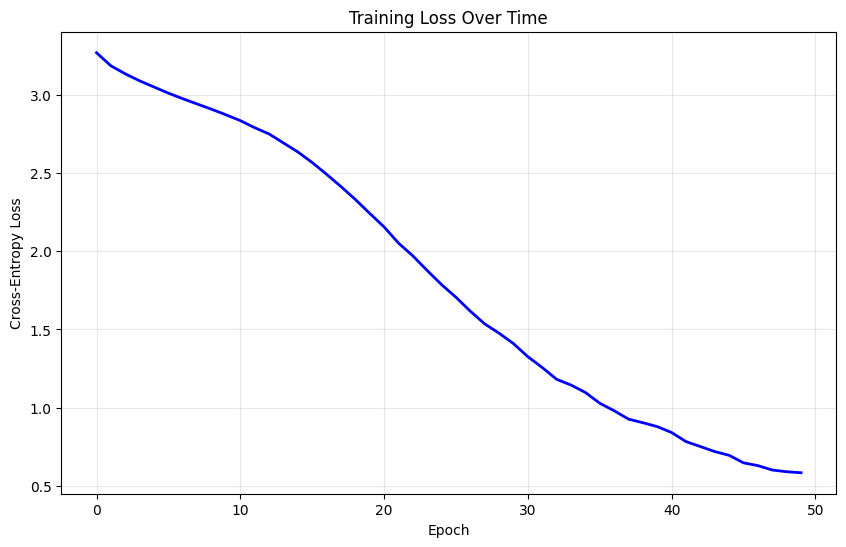

Final loss: 0.5854
Loss decreased by: 2.6818


In [46]:
# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, 'b-', linewidth=2)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss decreased by: {losses[0] - losses[-1]:.4f}")


## Text Generation

Now let's use our trained model to generate text:
1. Start with a seed token
2. Get model predictions
3. Sample next token from probability distribution
4. Add to sequence and repeat


In [47]:
def generate_text(model, start_tokens, max_new_tokens=10, temperature=1.0):
    """
    Generate text by sampling from the model
    
    Args:
        model: The trained TinyGPT model
        start_tokens: Initial token IDs to start generation [1, seq_len]
        max_new_tokens: How many new tokens to generate
        temperature: Controls randomness (higher = more random)
    """
    model.eval()  # Set to evaluation mode
    
    with torch.no_grad():  # Don't track gradients during generation
        tokens = start_tokens.clone()  # Copy starting tokens
        
        for _ in range(max_new_tokens):
            # Only use last block_size tokens if sequence gets too long
            input_tokens = tokens[:, -block_size:]
            
            # Get model predictions
            logits = model(input_tokens)           # [1, seq_len, vocab_size]
            next_token_logits = logits[:, -1, :]   # Get logits for last position [1, vocab_size]
            
            # Apply temperature scaling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature
            
            # Convert to probabilities
            probs = torch.softmax(next_token_logits, dim=-1)  # [1, vocab_size]
            
            # Sample next token
            next_token = torch.multinomial(probs, num_samples=1)  # [1, 1]
            
            # Add to sequence
            tokens = torch.cat([tokens, next_token], dim=1)
    
    return tokens

print("✅ Generation function ready!")


✅ Generation function ready!


In [48]:
# Generate some text samples
print("🎯 Generating text samples:\n")

for i in range(3):
    # Start with a random seed token
    seed = torch.randint(0, vocab_size, (1, 1))
    
    # Generate continuation
    generated = generate_text(
        model=model,
        start_tokens=seed,
        max_new_tokens=15,
        temperature=0.8  # Slight randomness
    )
    
    # Convert to letters and display
    generated_ids = generated[0].tolist()
    generated_text = ids_to_letters(generated_ids)
    seed_letter = ids_to_letters([generated_ids[0]])
    
    print(f"Sample {i+1}:")
    print(f"  Seed: '{seed_letter}'")
    print(f"  Generated: '{generated_text}'")
    print(f"  Length: {len(generated_text)} characters")
    print()


🎯 Generating text samples:

Sample 1:
  Seed: 'n'
  Generated: 'ndvayrkatvmtkhmp'
  Length: 16 characters

Sample 2:
  Seed: 's'
  Generated: 'smvzlndwhcsxgndc'
  Length: 16 characters

Sample 3:
  Seed: 'l'
  Generated: 'lnimgwxkfkpwsqfs'
  Length: 16 characters



## Summary

🎉 **Congratulations!** You've successfully:

1. ✅ Implemented a TinyGPT transformer model
2. ✅ Trained it on synthetic data  
3. ✅ Generated text samples

### Key Concepts Learned:
- **Transformer architecture**: Self-attention, positional encoding, causal masking
- **Language modeling**: Next-token prediction training objective
- **Text generation**: Autoregressive sampling from probability distributions

### Next Steps:
- Try training on real text data (Shakespeare, Wikipedia, etc.)
- Experiment with different model sizes and hyperparameters
- Add beam search or nucleus sampling for better generation
- Implement evaluation metrics (perplexity, BLEU scores)


In [50]:
# Final model statistics
print("📊 Final Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Context length: {block_size}")
print(f"  Hidden dimension: {d_model}")
print(f"  Attention heads: {nhead}")
print(f"  Transformer layers: {nlayers}")
print(f"  Final training loss: {losses[-1]:.4f}")
print("\n🎯 Model ready for inference!")


📊 Final Model Statistics:
  Total parameters: 405,274
  Vocabulary size: 26
  Context length: 16
  Hidden dimension: 128
  Attention heads: 4
  Transformer layers: 2
  Final training loss: 0.5854

🎯 Model ready for inference!
